In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from src.dataset.kay import load_dataset
from src.utils.util import prepare_fmri_data

from src.ml.test import test_model
from src.ml.train import train_model
from src.ml.dataset import FMRIDataset
from src.ml.model import FMRIClassifier
from src.ml.utils import plot_loss_acc_curves, generate_score_report

In [2]:
%matplotlib inline
sns.set_style("darkgrid")

title_size = 16
params = {'legend.fontsize': 14,
          'axes.labelsize': title_size - 2,
          'axes.titlesize': title_size,
          'xtick.labelsize': title_size - 4,
          'ytick.labelsize': title_size - 4,
          'axes.titlepad': 1.5 * title_size}

plt.rcParams.update(params)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


## Load Data

In [4]:
all_data = load_dataset(data_path="./../data/")

In [5]:
class_ignore_list = ["person", "fungus", "plant"]
roi_select_list = [1, 2, 3]

x_trainval, y_trainval = prepare_fmri_data(all_data=all_data, 
                                           data_subset = "train", 
                                           class_ignore_list=class_ignore_list, 
                                           label_level= 0 , 
                                           roi_select_list = roi_select_list)

# split trainval into train and val data
x_train, x_val, y_train, y_val = train_test_split(x_trainval, 
                                                  y_trainval, 
                                                  test_size=0.2, 
                                                  stratify=y_trainval,
                                                  random_state=42)


x_test, y_test = prepare_fmri_data(all_data=all_data, 
                                           data_subset = "test", 
                                           class_ignore_list=class_ignore_list, 
                                           label_level= 0 , 
                                           roi_select_list = roi_select_list)

In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((1393, 5166), (1393,), (349, 5166), (349,), (119, 5166), (119,))

In [7]:
class2idx = {k:i for i,k in enumerate(np.unique(y_trainval))}
idx2class = {v:k for k,v in class2idx.items()}

## Create Dataset and Dataloader

In [8]:
train_dataset = FMRIDataset(x_data=x_train, 
                             y_data = y_train, 
                             class2idx = class2idx)

val_dataset = FMRIDataset(x_data=x_val, 
                             y_data = y_val, 
                             class2idx = class2idx)

test_dataset = FMRIDataset(x_data = x_test, 
                            y_data = y_test, 
                            class2idx = class2idx)

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=64)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=64)

## Initialize Model

In [9]:
model = FMRIClassifier(num_features=train_dataset[0][0].shape[0], num_classes=len(class2idx))
model.to(device)

epochs = 15
criterion = nn.CrossEntropyLoss() #weight=class_weights.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)

## Train Model

In [10]:
loss_stats, acc_stats = train_model(
    model=model,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 01/15: | Train Loss: 1.95548 | Val Loss: 1.69924 | Train Acc: 24.136% | Val Acc: 19.500%
Epoch 02/15: | Train Loss: 1.71540 | Val Loss: 1.55162 | Train Acc: 30.864% | Val Acc: 34.333%
Epoch 03/15: | Train Loss: 1.56173 | Val Loss: 1.48687 | Train Acc: 37.273% | Val Acc: 41.833%
Epoch 04/15: | Train Loss: 1.44164 | Val Loss: 1.45592 | Train Acc: 43.227% | Val Acc: 48.833%
Epoch 05/15: | Train Loss: 1.41650 | Val Loss: 1.43898 | Train Acc: 44.909% | Val Acc: 49.833%
Epoch 06/15: | Train Loss: 1.43410 | Val Loss: 1.42727 | Train Acc: 44.182% | Val Acc: 49.833%
Epoch 07/15: | Train Loss: 1.38987 | Val Loss: 1.40417 | Train Acc: 46.364% | Val Acc: 53.000%
Epoch 08/15: | Train Loss: 1.38468 | Val Loss: 1.38938 | Train Acc: 45.864% | Val Acc: 52.000%
Epoch 09/15: | Train Loss: 1.36724 | Val Loss: 1.37455 | Train Acc: 46.909% | Val Acc: 50.333%
Epoch 10/15: | Train Loss: 1.35074 | Val Loss: 1.35978 | Train Acc: 45.091% | Val Acc: 52.167%
Epoch 11/15: | Train Loss: 1.35443 | Val Loss: 1.3

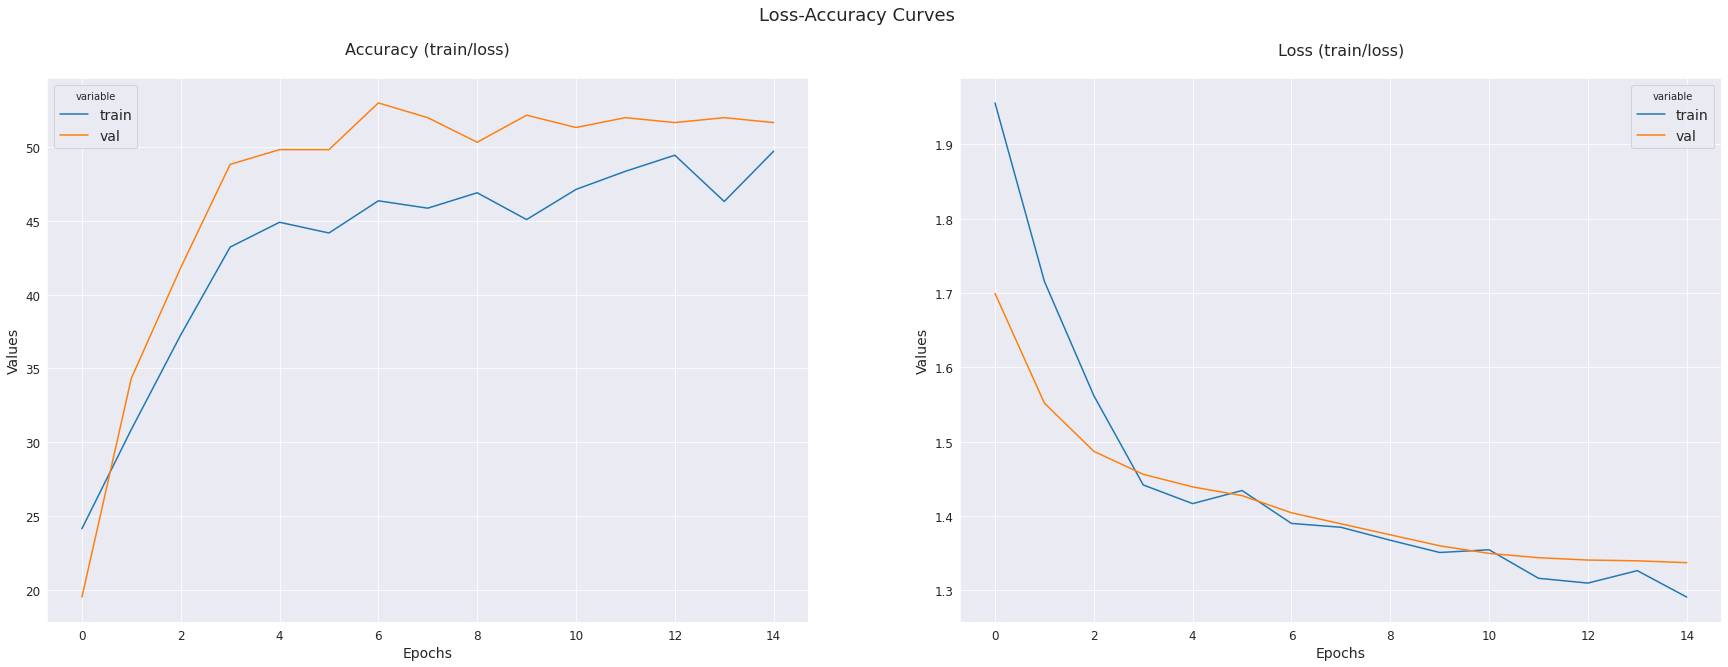

In [11]:
plot_loss_acc_curves(loss_stats, acc_stats)

## Test Model

In [12]:
y_true_list, y_pred_list = test_model(model, test_loader, device)

  0%|          | 0/2 [00:00<?, ?it/s]

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.37      0.48        54
           1       0.45      0.80      0.58        50
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10

    accuracy                           0.50       119
   macro avg       0.22      0.23      0.21       119
weighted avg       0.49      0.50      0.46       119






/home/akshaj/miniconda3/envs/decoding-thoughts/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/akshaj/miniconda3/envs/decoding-thoughts/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/akshaj/miniconda3/envs/decoding-thoughts/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

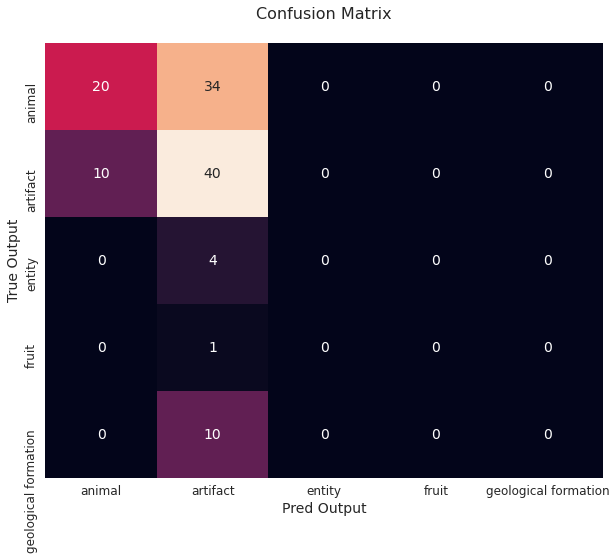

In [13]:
generate_score_report(y_true=y_true_list, y_pred=y_pred_list, idx2class=idx2class)